# <center>Классифкатор на minst
#### Задача:
Добиться от классифкатора на minst **переобучения** за счет изменения архитектуры и гиперпараметров

In [ ]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

In [19]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [ ]:
X_train = X_train.float()
X_test = X_test.float()

In [21]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [22]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

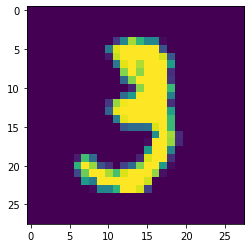

tensor(3)


In [23]:
import matplotlib.pyplot as plt
plt.imshow(X_train[10, :, :])
plt.show()
print(y_train[10])

In [ ]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [ ]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.ac2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.ac3 = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        x = self.fc4(x)
        return x
    
# mnist_net = MNISTNet(200)

In [26]:
torch.cuda.is_available()

True

In [ ]:
# !nvidia-smi

In [ ]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# mnist_net = mnist_net.to(device)
# list(mnist_net.parameters())

In [ ]:
# loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [31]:
%%time

#hyperparams
batch_size = 100
n_hidden_neurons = 1000
epochs = 200

# net initial
mnist_net = MNISTNet(n_hidden_neurons)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)


test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    with torch.no_grad():
        test_preds = mnist_net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test))
        
        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
        test_accuracy_history.append(accuracy)
        if epoch % 10 == 0:
            print(f"epoch {epoch} accuracy {round(accuracy.item(), 4)}")

epoch 0 accuracy 0.9527
epoch 10 accuracy 0.9777
epoch 20 accuracy 0.9797
epoch 30 accuracy 0.9789
epoch 40 accuracy 0.9785
epoch 50 accuracy 0.9818
epoch 60 accuracy 0.979
epoch 70 accuracy 0.9817
epoch 80 accuracy 0.9784
epoch 90 accuracy 0.9803
epoch 100 accuracy 0.9778
epoch 110 accuracy 0.981
epoch 120 accuracy 0.9764
epoch 130 accuracy 0.9783
epoch 140 accuracy 0.9708
epoch 150 accuracy 0.97
epoch 160 accuracy 0.9774
epoch 170 accuracy 0.9755
epoch 180 accuracy 0.9749
epoch 190 accuracy 0.9752
CPU times: user 7min 50s, sys: 1min 11s, total: 9min 2s
Wall time: 9min 5s


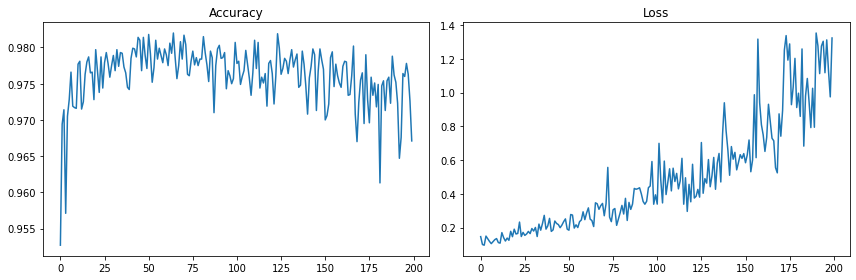

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].plot(test_accuracy_history)
axes[0].set_title("Accuracy")
axes[1].plot(test_loss_history)
axes[1].set_title("Loss")
fig.tight_layout()

**Вывод:**   
После 50 эпохи явное переобучение по accuracy. По loss переобучение гораздо раньше, это связано, скорее всего, с повышением уверенности сети. На мой взгляд, важным было добиться переобучения именно по accuracy

**Что сделано:**    
- добавлено 2 слоя
- нейронов в скрытых слоях - по 1000
- активация relu
- 200 эпох